# Exploratory Data Analysis – Adult Income Dataset

This notebook explores the preprocessed Adult Income dataset used for fairness-aware modeling.

- Check shapes and basic structure of the data
- Look at target distribution
- Inspect missing values
- Explore numeric and categorical features
- Compare train vs test splits for potential drift


## 1. Imports and data loading

We assume the file is stored at `data/processed/adult/adult_model_ready.csv` relative to the project root.


In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

PROJECT_ROOT = Path('..').resolve()
model_path = PROJECT_ROOT / 'data' / 'processed' / 'adult' / 'adult_model_ready.csv'

df = pd.read_csv(model_path)
print(f'Loaded dataset with shape: {df.shape}')
print('Income distribution:\n', df['income'].value_counts())
df_full = df.copy()

Loaded dataset with shape: (45194, 16)
Income distribution:
 income
<=50K    33988
>50K     11206
Name: count, dtype: int64


## 2. Train / test split and target variable

We split the data according to the `split` column (if present) and create a binary income target.


In [6]:
if 'split' in df_full.columns:
    df_train = df_full[df_full['split'] == 'train'].copy()
    df_test = df_full[df_full['split'] == 'test'].copy()
else:
    df_train = df_full.copy()
    df_test = None

print('Train size:', len(df_train))
print('Test size:', len(df_test) if df_test is not None else 0)


Train size: 30139
Test size: 15055


In [7]:
target_col = 'income'
assert target_col in df_full.columns, 'Expected column income in dataset'

# Typical Adult dataset has labels like '<=50K' and '>50K'
df_full['income_binary'] = df_full[target_col].astype(str).str.contains('>').astype(int)

if 'split' in df_full.columns:
    df_train['income_binary'] = df_full.loc[df_train.index, 'income_binary']
    if df_test is not None:
        df_test['income_binary'] = df_full.loc[df_test.index, 'income_binary']

print('Income binary distribution (counts):')
print(df_full['income_binary'].value_counts())
print('\nIncome binary distribution (proportions):')
print(df_full['income_binary'].value_counts(normalize=True))


Income binary distribution (counts):
income_binary
0    33988
1    11206
Name: count, dtype: int64

Income binary distribution (proportions):
income_binary
0    0.752047
1    0.247953
Name: proportion, dtype: float64


## 3. Basic dataset overview

Check column types, basic statistics and target distribution.


In [8]:
df_full.info()
display(df_full.describe())
display(df_full.describe(include='object'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45194 entries, 0 to 45193
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45194 non-null  int64 
 1   workclass       45194 non-null  object
 2   fnlwgt          45194 non-null  int64 
 3   education       45194 non-null  object
 4   education_num   45194 non-null  int64 
 5   marital_status  45194 non-null  object
 6   occupation      45194 non-null  object
 7   relationship    45194 non-null  object
 8   race            45194 non-null  object
 9   sex             45194 non-null  object
 10  capital_gain    45194 non-null  int64 
 11  capital_loss    45194 non-null  int64 
 12  hours_per_week  45194 non-null  int64 
 13  native_country  45194 non-null  object
 14  income          45194 non-null  object
 15  split           45194 non-null  object
 16  income_binary   45194 non-null  int64 
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_binary
count,45194.000000,4.519400e+04,45194.000000,45194.000000,45194.000000,45194.000000,45194.000000
mean,38.551755,1.897379e+05,10.119109,1102.112736,88.650308,40.941209,0.247953
std,13.215806,1.056407e+05,2.552057,7508.705003,405.075515,12.006449,0.431829
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173922e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783120e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.379030e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income,split
count,45194,45194,45194,45194,45194,45194,45194,45194,45194,45194
unique,7,16,7,14,6,5,2,41,2,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K,train
freq,33281,14777,21048,6015,18659,38877,30509,41270,33988,30139


## 4. Missing values

Identify columns with missing values and how frequent they are.


In [9]:
missing_counts = df_full.isna().sum()
missing_ratio = missing_counts / len(df_full)

missing = pd.concat([missing_counts, missing_ratio], axis=1)
missing.columns = ['n_missing', 'frac_missing']
missing = missing[missing['n_missing'] > 0].sort_values('frac_missing', ascending=False)

display(missing)


,n_missing,frac_missing


## 5. Numeric feature distributions and correlations

Plot histograms for numeric features and inspect correlations with the income target.


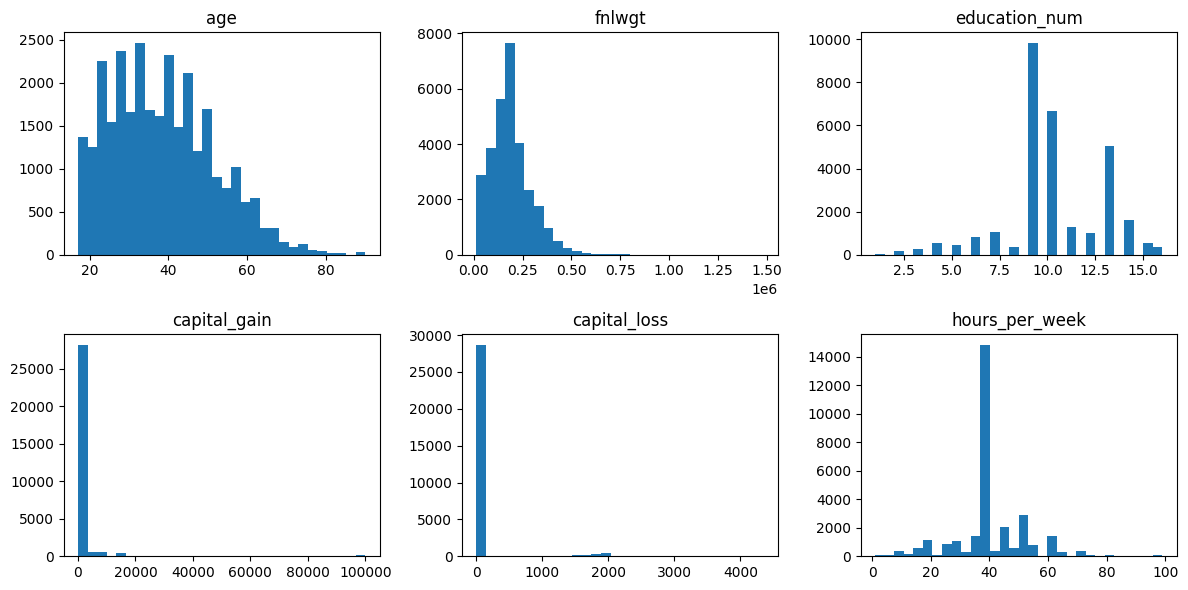

In [10]:
numeric_cols = df_full.select_dtypes(include=['number']).columns.tolist()

# Remove target and similar helper columns from generic numeric list
drop_candidates = ['income_binary']
numeric_cols = [c for c in numeric_cols if c not in drop_candidates]

if numeric_cols:
    n_cols = min(3, len(numeric_cols))
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, col in zip(axes, numeric_cols):
        ax.hist(df_train[col].dropna(), bins=30)
        ax.set_title(col)

    # Remove unused axes
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
else:
    print('No numeric columns found.')


In [11]:
if 'income_binary' in df_train.columns:
    corr = df_train.corr(numeric_only=True)['income_binary'].sort_values(ascending=False)
    display(corr)
else:
    print('income_binary not found in df_train.')


income_binary     1.000000
education_num     0.335413
age               0.242017
hours_per_week    0.229435
capital_gain      0.221204
capital_loss      0.150026
fnlwgt           -0.008992
Name: income_binary, dtype: float64

## 6. Categorical features and income rates

For each categorical feature, we look at value counts and the average income rate per category.


In [12]:
cat_cols = df_full.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [target_col, 'split']]

def summarize_categorical(df, col, target='income_binary', max_categories=20):
    vc = df[col].value_counts().head(max_categories)
    tmp = df[df[col].isin(vc.index)].copy()
    summary = (
        tmp.groupby(col)[target]
        .agg(['count', 'mean'])
        .rename(columns={'mean': f'{target}_rate'})
        .sort_values('count', ascending=False)
    )
    return summary

for col in cat_cols:
    print(f'\n=== {col} ===')
    display(summarize_categorical(df_train, col))



=== workclass ===


,count,income_binary_rate
workclass,,
Private,22264,0.218918
Self-emp-not-inc,2498,0.285829
Local-gov,2067,0.294630
State-gov,1279,0.268960
Self-emp-inc,1074,0.558659
Federal-gov,943,0.387063
Without-pay,14,0.000000



=== education ===


,count,income_binary_rate
education,,
HS-grad,9834,0.164328
Some-college,6669,0.200180
Bachelors,5042,0.421658
Masters,1626,0.564576
Assoc-voc,1307,0.263198
11th,1048,0.056298
Assoc-acdm,1008,0.253968
10th,820,0.071951
7th-8th,556,0.062950



=== marital_status ===


,count,income_binary_rate
marital_status,,
Married-civ-spouse,14059,0.455011
Never-married,9711,0.048399
Divorced,4212,0.107312
Separated,939,0.070288
Widowed,827,0.096735
Married-spouse-absent,370,0.083784
Married-AF-spouse,21,0.476190



=== occupation ===


,count,income_binary_rate
occupation,,
Prof-specialty,4034,0.448686
Craft-repair,4025,0.225590
Exec-managerial,3991,0.485342
Adm-clerical,3719,0.133907
Sales,3584,0.270647
Other-service,3209,0.041134
Machine-op-inspct,1964,0.124236
Transport-moving,1572,0.202926
Handlers-cleaners,1349,0.061527



=== relationship ===


,count,income_binary_rate
relationship,,
Husband,12457,0.455728
Not-in-family,7714,0.106689
Own-child,4462,0.014343
Unmarried,3211,0.066334
Wife,1406,0.493599
Other-relative,889,0.039370



=== race ===


,count,income_binary_rate
race,,
White,25912,0.263855
Black,2816,0.129972
Asian-Pac-Islander,894,0.277405
Amer-Indian-Eskimo,286,0.118881
Other,231,0.090909



=== sex ===


,count,income_binary_rate
sex,,
Male,20366,0.313955
Female,9773,0.113783



=== native_country ===


,count,income_binary_rate
native_country,,
United-States,27487,0.254411
Mexico,606,0.054455
Philippines,188,0.319149
Germany,128,0.343750
Puerto-Rico,109,0.110092
Canada,107,0.336449
El-Salvador,100,0.090000
India,100,0.400000
Cuba,92,0.271739


## 7. Train vs test drift check

Compare numeric and categorical distributions between train and test splits to detect potential drift.


In [13]:
if df_test is not None:
    num_cols = df_train.select_dtypes(include=['number']).columns.tolist()
    drop_cols = ['income_binary']
    num_cols = [c for c in num_cols if c not in drop_cols]

    summary_train = df_train[num_cols].describe().T[['mean', 'std']]
    summary_test = df_test[num_cols].describe().T[['mean', 'std']]

    summary = summary_train.join(summary_test, lsuffix='_train', rsuffix='_test')
    summary['mean_diff_abs'] = (summary['mean_test'] - summary['mean_train']).abs()

    display(summary.sort_values('mean_diff_abs', ascending=False).head(15))
else:
    print('No test split available.')


,mean_train,std_train,mean_test,std_test,mean_diff_abs
fnlwgt,189795.025980,105658.624341,189623.397077,105608.086413,171.628902
capital_gain,1092.841202,7409.110596,1120.673663,7704.433932,27.832461
capital_loss,88.439928,404.445239,89.071471,406.347469,0.631543
age,38.441720,13.131426,38.772036,13.380850,0.330316
hours_per_week,40.934703,11.978753,40.954234,12.062092,0.019532
education_num,10.122532,2.548738,10.112255,2.558759,0.010277


In [14]:
if df_test is not None and cat_cols:
    rows = []
    for col in cat_cols:
        train_dist = (
            df_train[col]
            .value_counts(normalize=True)
            .rename('train')
        )
        test_dist = (
            df_test[col]
            .value_counts(normalize=True)
            .rename('test')
        )
        combined = train_dist.to_frame().join(test_dist, how='outer').fillna(0)
        combined['abs_diff'] = (combined['test'] - combined['train']).abs()
        combined['feature'] = col
        rows.append(combined.reset_index().rename(columns={col: 'category'}))

    drift_cat = pd.concat(rows, ignore_index=True)

    display(
        drift_cat.sort_values('abs_diff', ascending=False)
        .groupby('feature')
        .head(5)
    )
else:
    print('No test split or no categorical columns.')


,category,train,test,abs_diff,feature
45,Not-in-family,0.255947,0.263899,0.007952,relationship
22,Some-college,0.221275,0.213949,0.007326,education
2,Private,0.738711,0.731783,0.006927,workclass
19,Masters,0.053950,0.058917,0.004967,education
47,Own-child,0.148047,0.143408,0.004640,relationship
42,Tech-support,0.030227,0.033743,0.003516,occupation
95,United-States,0.912008,0.915510,0.003502,native_country
4,Self-emp-not-inc,0.082883,0.086151,0.003268,workclass
8,11th,0.034772,0.037928,0.003155,education
39,Prof-specialty,0.133847,0.130787,0.003059,occupation
